# Data Loading and Previewing



In [1]:
import pandas as pd

rawData = pd.read_csv('https://raw.githubusercontent.com/skduong/anuran-calls/master/Frogs_MFCCs.csv')
rawData.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,-0.075622,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,-0.095004,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,-0.072827,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,-0.162258,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,-0.100749,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [2]:
data = rawData[rawData.columns[:23]] #focus on Family classification
data['Family'].value_counts() #get class balance

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

Rebalancing is needed: undersample Leptodactylidae, oversamle Dendrobatidae with SMOTE, remove Bufondidae

In [3]:
import numpy as np
from imblearn.over_sampling import SMOTE

lepto = data.loc[data['Family'] == 'Leptodactylidae']
hyli = data.loc[data['Family'] == 'Hylidae']
dendro = data.loc[data['Family'] == 'Dendrobatidae']

#oversample dendro classes to match dendro
subset = pd.concat([hyli, dendro])
X = subset.drop(['Family'], 1)
y = subset['Family']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y) #X = data matrix, y = labels
oversample_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], 1)
oversample_df.columns = lepto.columns.values
#pd.Series(y).value_counts()

#randomly undersample lepto by 1420 cases
undersample = lepto.drop(np.random.choice(lepto.index, 1420, False))

#rebalanced data
data = pd.concat([undersample, oversample_df])
data['Family'].value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Leptodactylidae    3000
Dendrobatidae      2165
Hylidae            2165
Name: Family, dtype: int64

Improved balanced compared to before. Not perfect, but it's a compromise between losing too many Leptodactylidae cases and having heavy imbalance with the major class.

In [5]:
lepto = data.loc[data['Family'] == 'Leptodactylidae']
dendro = data.loc[data['Family'] == 'Dendrobatidae']
hyli = data.loc[data['Family'] == 'Hylidae']

data.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000
mean,0.990916,0.321586,0.258918,0.394478,0.152139,0.122357,0.014456,-0.013803,0.085127,0.058419,-0.068449,0.008165,0.084662,0.006824,-0.037600,0.006899,0.030184,0.011710,-0.020888,-0.038266,0.020413,0.057272
std,0.064535,0.208506,0.280895,0.170987,0.172774,0.116815,0.182645,0.119450,0.186218,0.142114,0.180453,0.163629,0.207084,0.162353,0.191063,0.124647,0.151435,0.080226,0.085184,0.088769,0.079091,0.116639
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.539779,-0.410417,-0.452555,-0.474302,-0.513460,-0.952266,-0.901989,-0.799441,-0.644116,-0.590380,-0.717156,-0.498675,-0.421480,-0.759322,-0.680745,-0.360914,-0.430812,-0.375461
25%,1.000000,0.187045,0.046558,0.289549,0.060797,0.036471,-0.124962,-0.102094,-0.054338,-0.003240,-0.228334,-0.098610,-0.074550,-0.099302,-0.209588,-0.086523,-0.118198,-0.034625,-0.080540,-0.097100,-0.035174,-0.022517
50%,1.000000,0.306403,0.231146,0.393380,0.163856,0.113550,-0.025048,-0.007508,0.131719,0.066214,-0.065970,0.023505,0.073479,-0.016784,-0.048065,0.014432,0.037254,0.013773,-0.012165,-0.038144,0.010290,0.038473
75%,1.000000,0.434073,0.398207,0.530789,0.242629,0.199664,0.108792,0.064856,0.235993,0.138027,0.062539,0.097809,0.277494,0.130030,0.137894,0.078305,0.168227,0.062254,0.028743,0.015459,0.071801,0.164601
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,0.696887,0.551762,0.738033,0.522768,0.523033,0.669470,0.945710,0.566873,0.668924,0.670700,0.681157,0.614064,0.574209,0.467831,0.387363,0.432207


#Evaluating Feature Discriminating Power 

To see if any of the MFCCs have more influence on class decision, the discriminating power for each feature, F, between disjoint classes CLi and CLj (with combined size N) will be calculated using:

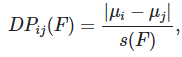   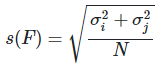



In [57]:
def DP(i, j): #take 2 classes, give discriminating power between them for all 22 features
  i = i.drop(['Family'],1); j = j.drop(['Family'],1)
  N = len(i)+len(j)
  sF = ((i.var()+j.var())/N)**0.5
  DP = abs(i.mean()-j.mean())/sF
  return DP.sort_values(0,False)

ld = DP(lepto, dendro)
dh = DP(dendro, hyli)
lh = DP(lepto, hyli)

print('Top 3 descriminating features for each pair of classes: \n', 'Lepto & Dendro:\n', ld.iloc[0:3], '\n\nDendro & Hyli:\n',dh.iloc[0:3], '\n\nLepto & Hyli:\n', lh.iloc[0:3], sep='')

Top 3 descriminating features for classes: 
Lepto & Dendro:
MFCCs_17    159.209342
MFCCs_15    120.418134
MFCCs_19    115.412780
dtype: float64

Dendro & Hyli:
MFCCs_ 3    92.045101
MFCCs_14    77.600980
MFCCs_16    70.627657
dtype: float64

Lepto & Hyli:
MFCCs_19    89.496928
MFCCs_22    86.511274
MFCCs_17    72.955578
dtype: float64


It appears that MFCCs 17 and 19 are the most influential in distinguishing Leptodactylidae frogs from the other 2. 

(array([1.000e+00, 5.000e+00, 5.800e+01, 6.440e+02, 1.287e+03, 1.420e+02,
        2.400e+01, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.38965599, -0.2932695 , -0.196883  , -0.1004965 , -0.00411001,
         0.09227649,  0.18866299,  0.28504948,  0.38143598,  0.47782248,
         0.57420897]),
 <a list of 10 Patch objects>)

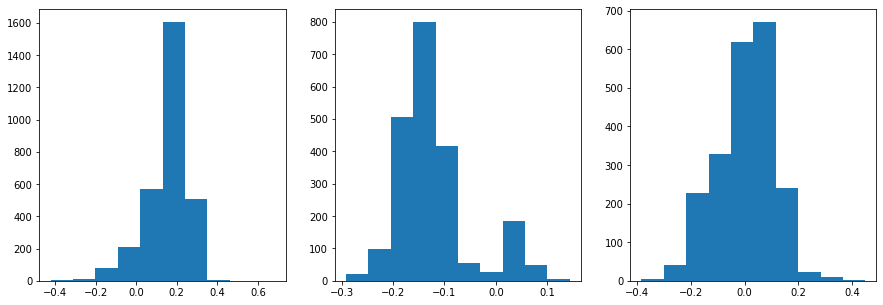

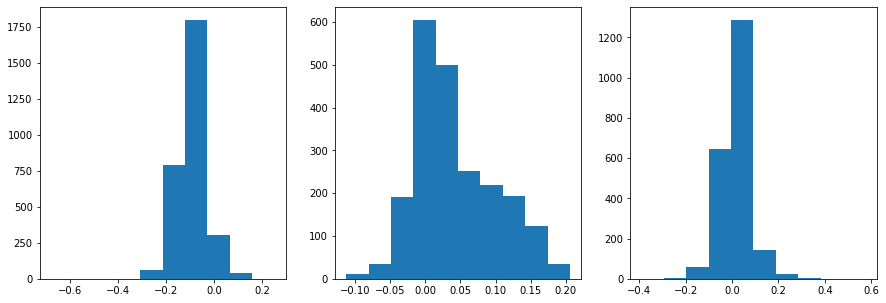

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(lepto['MFCCs_17'])
axes[1].hist(dendro['MFCCs_17'])
axes[2].hist(hyli['MFCCs_17'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(lepto['MFCCs_19'])
axes[1].hist(dendro['MFCCs_19'])
axes[2].hist(hyli['MFCCs_19'])

We can visually see why MFCCs 17 (top) & 19 (bottom) have such a high discriminating power. For each class, these values take on a distinct range (eg. MFCC17 is mostly positive for Leptodactylidae, negative for Dendrobatidae, and very close to zero for Hylidae). 

In [52]:
(abs(lepto.mean()-hyli.mean())/((lepto.var(axis=0)+hyli.var(axis=0))/(len(lepto)+len(hyli)))**0.5).sort_values(0,False)

DP(lepto, hyli).iloc[0:3]

MFCCs_19    89.496928
MFCCs_22    86.511274
MFCCs_17    72.955578
dtype: float64